In [27]:
from clearml import Task
task_filter={
    # filter out archived Tasks
    'system_tags': ['-archived'],
    # only completed & published Tasks
    'status': ['completed'],
    # only training type Tasks
    'type': ['training']
}
# Initialize the ClearML Task object
task_list_remove = Task.get_tasks(
    task_ids=None,  # type Optional[Sequence[str]]
    project_name="AI Fairness",  # Optional[str]
    task_name=None,  # Optional[str]
    task_filter=task_filter
)

In [28]:
len(task_list_remove)

35

In [29]:
from tqdm import tqdm
for i in tqdm(task_list_remove):
    try:
        i.delete()
    except Exception:
        pass

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [03:15<00:00,  5.57s/it]


In [221]:
class LocalTask:
    def __init__(self, task_):
        self.remote_task = task_
        self.params = dict()
        self.scalars = dict()
        self.download_data()
        
    def get_parameters_as_dict(self):
        return self.params
    
    def get_reported_scalars(self):
        return self.scalars
    
    def download_data(self):
        try:
            self.scalars = self.remote_task.get_reported_scalars()
        except Exception as e:
            pass
        try:
            self.params = self.remote_task.get_parameters_as_dict()
        except Exception as e:
            pass

In [222]:
import ast
class TaskListFilter:
    def __init__(self, task_list):
        self.task_list = task_list
        self.params = [task.get_parameters_as_dict() for task in task_list]
        self.scalars = [task.get_reported_scalars() for task in task_list]
        
    def typeconv(self, in_val, out_val):
        out_type = type(out_val)
        try:
            res_val = out_type(in_val)
            if out_type is list and len(in_val) > 0:
                res_val = ast.literal_eval(in_val)
            return res_val
        except Exception as e:
            print(e)

    def filter_by_args(self, args_set, page='Args'):
        filtered_tasks = []
        for args in args_set:
            for param, task in zip(self.params, self.task_list):
                if all(key in param[page].keys() and 
                       self.typeconv(param[page][key], value) == value for key, value in args.items()):
                    filtered_tasks.append(task)
        return filtered_tasks

    def extract_scalar_values(self, keys):
        values = []
        for scalar in self.scalars:
            nested_dict = scalar
            for key in keys:
                nested_dict = nested_dict[key]
            values.append(nested_dict)
        return values
    
    def extract_scalar_value(self, keys, id_=0):
        values = []
        nested_dict = self.scalars[id_]
        for key in keys:
            nested_dict = nested_dict[key]
        return nested_dict

In [223]:
class TaskListPipeline:
    def __init__(self, task_list):
        self.task_list = task_list
        self.operations = []
        
    def filter_by_args(self, *args, page='Args'):
        self.operations.append(lambda tasks: TaskListFilter(tasks).filter_by_args(list(args), page))
        return self
        
    def extract_scalar_values(self, keys):
        self.operations.append(lambda tasks: [TaskListFilter([task]).extract_scalar_value(keys) for task in tasks])
        return self
        
    def run(self):
        tasks = self.task_list
        for operation in self.operations:
            tasks = operation(tasks)
        return tasks


In [227]:
pipeline = TaskListPipeline(task_list)
filtered_tasks = pipeline.filter_by_args(
    {'arch': 'EOD', 'privacy_in':['encoder_classifier']}
).run()

In [228]:
eps_pipe = TaskListPipeline(filtered_tasks)
eps_tasks = eps_pipe.filter_by_args(*[{'eps':i} for i in [1,3,10, 30]]).extract_scalar_values(['ΔEOD', 'Eq_Odds test', 'y', -1]).run()

(array([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.]),
 array([0.0076889 , 0.02114592, 0.03460294, 0.04805996, 0.06151699,
        0.07497401, 0.08843103, 0.10188805, 0.11534508, 0.1288021 ,
        0.14225912]),
 <BarContainer object of 10 artists>)

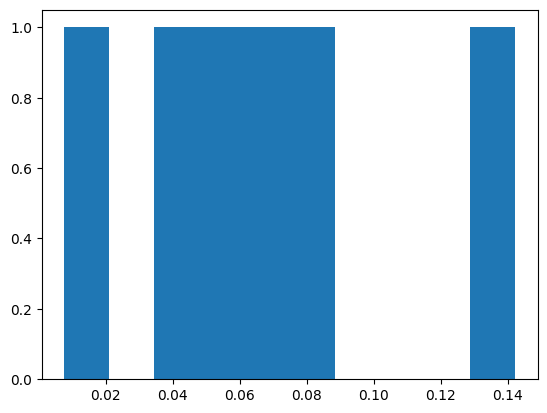

In [229]:
import numpy as np
import matplotlib.pyplot as plt 
x = [eps_tasks[int(i * len(eps_tasks)/4):int((i+1) * len(eps_tasks)/4)] for i in range(4)]
plt.hist(x[3])

In [148]:
for i in filtered_tasks:
    print(i)

-7.552766799926758
-8.713380813598633
0.33391308784484863
-8.529150009155273
-9.071523666381836
-10.262397766113281


In [101]:
filter_ = TaskListFilter(task_list)
filter_.extract_scalar_value(['Adversary Loss', 'train loss', 'name'])

'train loss'

In [68]:
type(task_list[0].get_reported_scalars()['ΔDP']['Dem_Par test']['x'])

list

In [ ]:
from tqdm import tqdm
def remote2local(tasks):
    local_tasks = [LocalTask(task) for task in tqdm(tasks)]
    return local_tasks

In [1]:
from clearml import Task

task_filter={
    # filter out archived Tasks
    'system_tags': ['archived'],
    # only completed & published Tasks
    'status': ['completed'],
    # only training type Tasks
    'type': ['training']
}

task_list_ = Task.get_tasks(
    task_ids=None,  # type Optional[Sequence[str]]
    project_name="AI Fairness",  # Optional[str]
    task_name=None,  # Optional[str]
    task_filter=task_filter  # Optional[Dict]
)

In [26]:
task_list_[0].download_artifacts()

AttributeError: 'Task' object has no attribute 'download_artifacts'

In [ ]:
task_list = remote2local(task_list_)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [01:26<00:00,  1.25it/s]


In [10]:
for k in task_list[0].get_parameters_as_dict().keys():
    print(k, task_list[0].get_parameters_as_dict()[k].keys())
print('='*20)
for s in task_list[0].get_reported_scalars().keys():
    print(s, task_list[0].get_reported_scalars()[s].keys())

Args dict_keys(['activ_adv', 'activ_ae', 'activ_class', 'adepth', 'adv_on_batch', 'advweight', 'aeweight', 'age_high', 'age_low', 'arch', 'awidths', 'batch', 'cdepth', 'check_acc', 'classweight', 'cwidths', 'data_dir', 'dataset', 'delta', 'e_activ_adv', 'e_activ_ae', 'e_activ_class', 'edepth', 'epoch', 'eps', 'eval_step_fair', 'ewidths', 'grad_clip_adv', 'grad_clip_ae', 'grad_clip_class', 'lr_adv', 'lr_enc_class', 'max_grad_norm', 'n_classes', 'n_features', 'n_groups', 'no_cuda', 'only_download_data', 'optimizer_adv', 'optimizer_enc_class', 'privacy_in', 'seed', 'sensattr', 'xavier', 'zdim'])
General dict_keys(['Sensattr ones test', 'Sensattr ones train', 'Test size', 'Train size', 'arch', 'dataset', 'delta', 'eps', 'max_grad_norm'])
:monitor:machine dict_keys(['cpu_usage', 'disk_free_percent', 'memory_free_gb', 'memory_used_gb', 'network_rx_mbs', 'network_tx_mbs'])
Accuracy dict_keys(['Dem_Par test', 'Dem_Par test NN', 'Dem_Par train', 'Dem_Par train NN', 'Unfair test', 'Unfair train'

In [14]:
sensattr = ['sex']
ages = [(71, 75)]
privacy_in = [[]]#[['autoencoder'], ['classifier'], ['adversary'], []]
eps = [1]#, 3, 10, 30]
arch = ['DP', 'EOD']#, 'EOD']
arch_ = ['']
len(task_list)

107

In [15]:
dp = []
eod = []
eop = []
acc = []
for i in task_list:
    p = i.get_parameters_as_dict()
    if  p['Args']['arch']=='EOD':
        scalars = i.get_reported_scalars()
        dp.append(scalars['ΔDP'][f'Eq_Odds test']['y'][-1])
        eod.append(scalars['ΔEOD'][f'Eq_Odds test']['y'][-1])
        eop.append(scalars['ΔEOP'][f'Eq_Odds test']['y'][-1])
        acc.append(scalars['Accuracy'][f'Eq_Odds test']['y'][-1])

In [16]:
import numpy as np
dp_avg = np.mean(dp)
eod_avg = np.mean(eod)
eop_avg = np.mean(eop)
acc_avg = np.mean(acc)
dp_std = np.std(dp)
eod_std = np.std(eod)
eop_std = np.std(eop)
acc_std = np.std(acc)

print(dp_avg, dp_std)
print(eod_avg, eod_std)
print(eop_avg, eop_std)
print(acc_avg, acc_std)

0.05344730425901987 0.03727138208341677
0.07529622550053452 0.05666246294199928
0.04719987596143727 0.04377523316592839
0.7758403685357835 0.017976399951984284


In [17]:
dp = []
eod = []
eop = []
acc = []
for i in task_list:
    p = i.get_parameters_as_dict()
    if  p['Args']['arch']=='DP':
        scalars = i.get_reported_scalars()
        dp.append(scalars['ΔDP'][f'Dem_Par test']['y'][-1])
        eod.append(scalars['ΔEOD'][f'Dem_Par test']['y'][-1])
        eop.append(scalars['ΔEOP'][f'Dem_Par test']['y'][-1])
        acc.append(scalars['Accuracy'][f'Dem_Par test']['y'][-1])

In [18]:
import numpy as np
dp_avg = np.mean(dp)
eod_avg = np.mean(eod)
eop_avg = np.mean(eop)
acc_avg = np.mean(acc)
dp_std = np.std(dp)
eod_std = np.std(eod)
eop_std = np.std(eop)
acc_std = np.std(acc)

print(dp_avg, dp_std)
print(eod_avg, eod_std)
print(eop_avg, eop_std)
print(acc_avg, acc_std)

0.05947138448597266 0.042715466869049326
0.0884875236254818 0.059521827208078054
0.05914566134770383 0.045159304111171715
0.7819082736968994 0.02130639132308839


In [19]:
import itertools
import ast
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
comb = list(itertools.product(sensattr, ages, privacy_in, arch))
metric_name = ['Accuracy', 'Accuracy Unfair', 'Accuracy AE',
               'ΔDP', 'ΔDP Unfair', 'ΔDP AE',
               'ΔEOD', 'ΔEOD Unfair', 'ΔEOD AE',
               'Acc/Fairness DP', 'Acc/Fairness DP Unfair', 'Acc/Fairness EOD', 'Acc/Fairness EOD Unfair']
print(comb)

[('sex', (71, 75), [], 'DP'), ('sex', (71, 75), [], 'EOD')]


In [8]:
def gen_label(l):
    str_ = l[0] if l[0] == 'age' else 'gender'
    if l[0] == 'age':
        str_ += f' {l[1][0]}-{l[1][1]}'
    str_+='|'
    if len(l[2]) > 0:
        str_ += ' Privacy in'
    else:
        str_ += ' No privacy'
    for p in l[2]:
        str_ += f' {p}'
    str_+='|'
    str_ += f' {l[3]}'
    return str_

In [9]:
all_metrics = []
for c in tqdm(comb):
    metrics = {n:{k:[] for k in eps} for n in metric_name}
    for task in task_list:
        p = task.get_parameters_as_dict()
        p_in = ast.literal_eval(p['Args']['privacy_in']) if len(p['Args']['privacy_in']) > 0 else []
        if all([
            p['Args']['sensattr'] == c[0], p_in == c[2], p['Args']['arch'] == c[3]
        ]):
            if p['Args']['aeweight'] == '1' and p_in != []:
                scalars = task.get_reported_scalars()
                arch_ = p['General']['arch']
                e = int(p['Args']['eps'])
                metrics['Accuracy AE'][e].append(scalars['Accuracy'][f'{arch_} test']['y'][-1])
                metrics['ΔDP AE'][e].append(scalars['ΔDP'][f'{arch_} test']['y'][-1])
                metrics['ΔEOD AE'][e].append(scalars['ΔEOD'][f'{arch_} test']['y'][-1])
            else:
                scalars = task.get_reported_scalars()
                arch_ = p['General']['arch']
                e = int(p['Args']['eps'])
                metrics['Acc/Fairness DP'][e].append(scalars['Test Acc/Fair'][f'DP']['y'][-1])
                metrics['Acc/Fairness DP Unfair'][e].append(scalars['Test Acc/Fair'][f'DP Unfair']['y'][-1])
                metrics['Acc/Fairness EOD'][e].append(scalars['Test Acc/Fair'][f'EOD']['y'][-1])
                metrics['Acc/Fairness EOD Unfair'][e].append(scalars['Test Acc/Fair'][f'EOD Unfair']['y'][-1])
                metrics['Accuracy'][e].append(scalars['Accuracy'][f'{arch_} test']['y'][-1])
                metrics['ΔDP'][e].append(scalars['ΔDP'][f'{arch_} test']['y'][-1])
                metrics['ΔEOD'][e].append(scalars['ΔEOD'][f'{arch_} test']['y'][-1])
                metrics['Accuracy Unfair'][e].append(scalars['Accuracy']['Unfair test']['y'][-1])
                metrics['ΔDP Unfair'][e].append(scalars['ΔDP']['Unfair test']['y'][-1])
                metrics['ΔEOD Unfair'][e].append(scalars['ΔEOD']['Unfair test']['y'][-1])
    for m in metrics:
        for i in metrics[m]:
            metrics[m][i] = (np.mean(metrics[m][i]), np.std(metrics[m][i], ddof=1), metrics[m][i])
    all_metrics.append(metrics)
    
            

  0%|                                                                                                                                          | 0/1 [00:00<?, ?it/s]D:\work\Projects\Programming\PythonProjects\DPFairDeepLearning\venv\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\work\Projects\Programming\PythonProjects\DPFairDeepLearning\venv\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\work\Projects\Programming\PythonProjects\DPFairDeepLearning\venv\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
D:\work\Projects\Programming\PythonProjects\DPFairDeepLearning\venv\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(ar

In [477]:
def gen_l(name):
    l = []
    for s, m in enumerate(all_metrics):
        mean, std, raw = [], [], []
        for i in m[name]:
            mean.append(m[name][i][0])
            std.append(m[name][i][1])
            raw.append(m[name][i][2])
        l.append([mean, std, raw])
    return l

In [478]:

def plot_res(fig_, ax_, l, name, label_list):
    for j, i in enumerate(l):
        ax_.bar(np.arange(len(eps)) + 0.8/len(l)*j, i[0], yerr=i[1], width=0.8/len(l), label=gen_label(label_list[j]))
        print(gen_label(label_list[j]), [round(s,3) for s in i[0]], [round(s,3) for s in i[1]])
    ax_.set_title(f'Dependence of {name} on epsilon')
    ax_.set_xticks(np.arange(len(eps)))
    ax_.set_xticklabels(eps)
    ax_.set_xlabel('eps')
    ax_.set_ylabel(name)
    ax_.legend(loc=1)
    fig_.tight_layout()
    return ax

In [479]:
def add_no_pr(ax_, g, comb_, n='Accuracy', color='r'):
    from matplotlib.collections import LineCollection
    x = np.arange(-0.2 ,len(eps))
    y = np.repeat(g[0][0], len(x))
    print(gen_label(comb_), round(g[0][0],3), round(g[1][0],3))
    ax_.plot(x, y, label=gen_label(comb_),c=color)
    ax_.legend(loc=1)
    return ax_

In [519]:
def add_unfair(ax_, n='Accuracy'):
    x = np.arange(-0.2 ,len(eps))
    y = np.repeat(gen_l(f'{n} Unfair')[0][0][0], len(x))
    print('gender| No privacy| Unfair', gen_l(f'{n} Unfair')[0][0][0])
    ax_.plot(x, y, label='gender| No privacy| Unfair',c='black', linestyle='dashed')
    ax_.legend(loc=3)
    return ax_

## test

gender| Privacy in autoencoder| DP [0.136, 0.153, 0.15, 0.114] [0.019, 0.004, 0.009, 0.062]
gender| Privacy in classifier| DP [0.12, 0.129, 0.115, 0.12] [0.054, 0.035, 0.036, 0.02]
gender| Privacy in adversary| DP [0.136, 0.139, 0.151, 0.145] [0.028, 0.015, 0.005, 0.007]
gender| No privacy| DP 0.13 0.05
gender| No privacy| Unfair 0.16537350416183472
gender| Privacy in autoencoder| EOD [0.133, 0.15, 0.157, 0.153] [0.034, 0.01, 0.013, 0.006]
gender| Privacy in classifier| EOD [0.111, 0.124, 0.132, 0.122] [0.037, 0.023, 0.018, 0.018]
gender| Privacy in adversary| EOD [0.128, 0.148, 0.137, 0.151] [0.042, 0.004, 0.021, 0.006]
gender| No privacy| EOD 0.153 0.006
gender| No privacy| Unfair 0.16537350416183472
gender| Privacy in autoencoder| DP [0.136, 0.153, 0.15, 0.114] [0.019, 0.004, 0.009, 0.062]
gender| Privacy in autoencoder| EOD [0.133, 0.15, 0.157, 0.153] [0.034, 0.01, 0.013, 0.006]
gender| No privacy| DP 0.13 0.05
gender| No privacy| EOD 0.153 0.006
gender| No privacy| Unfair 0.165373

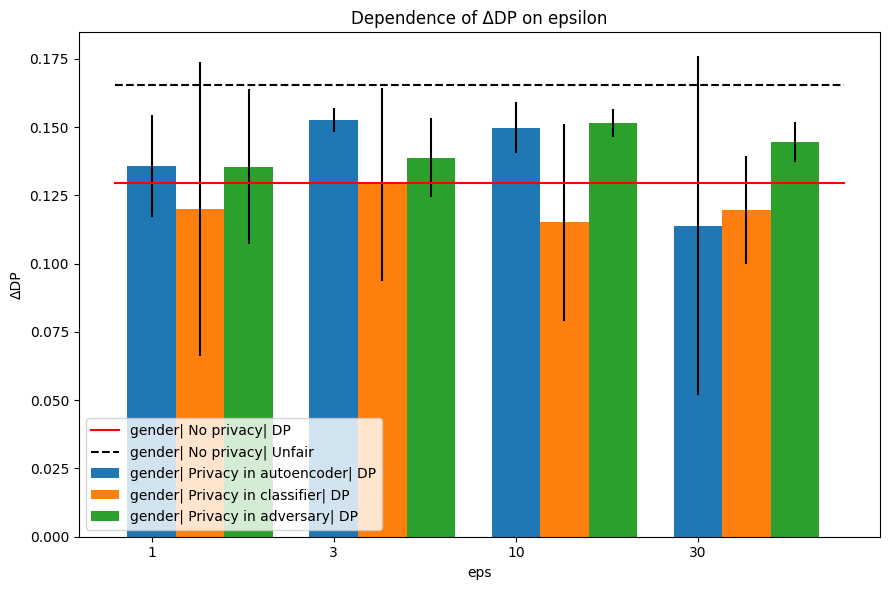

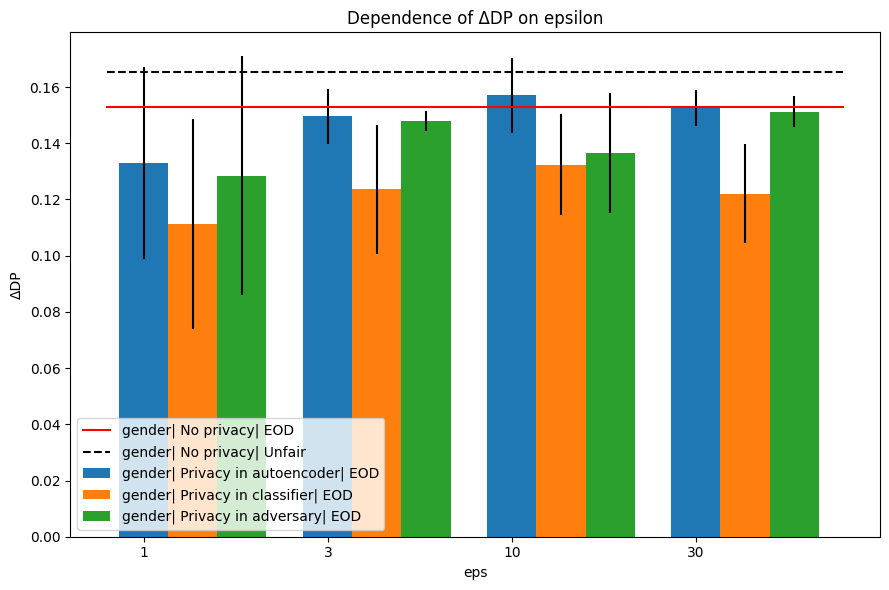

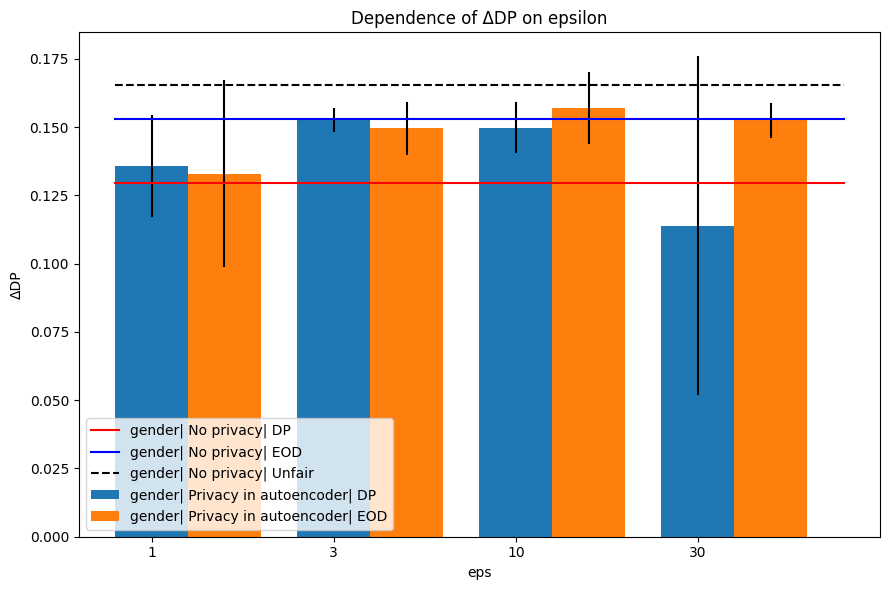

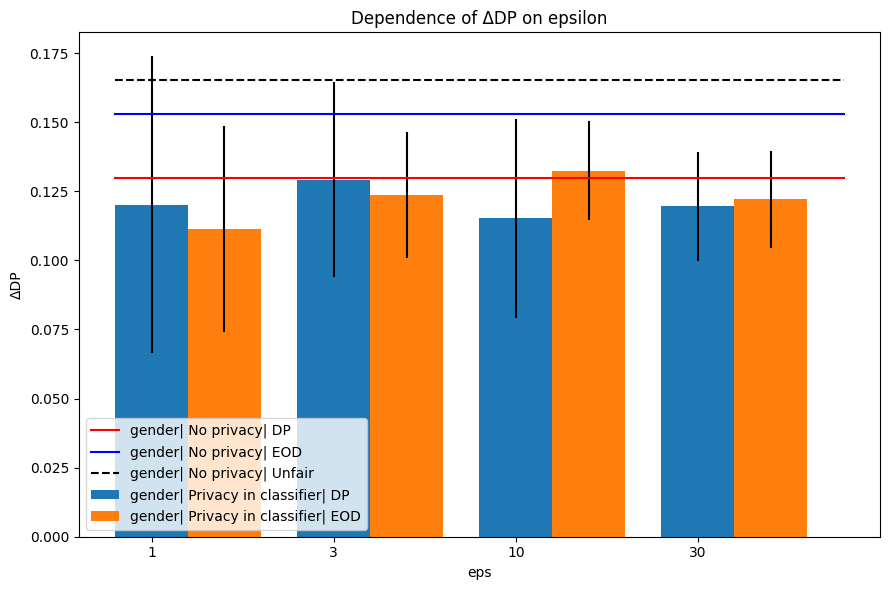

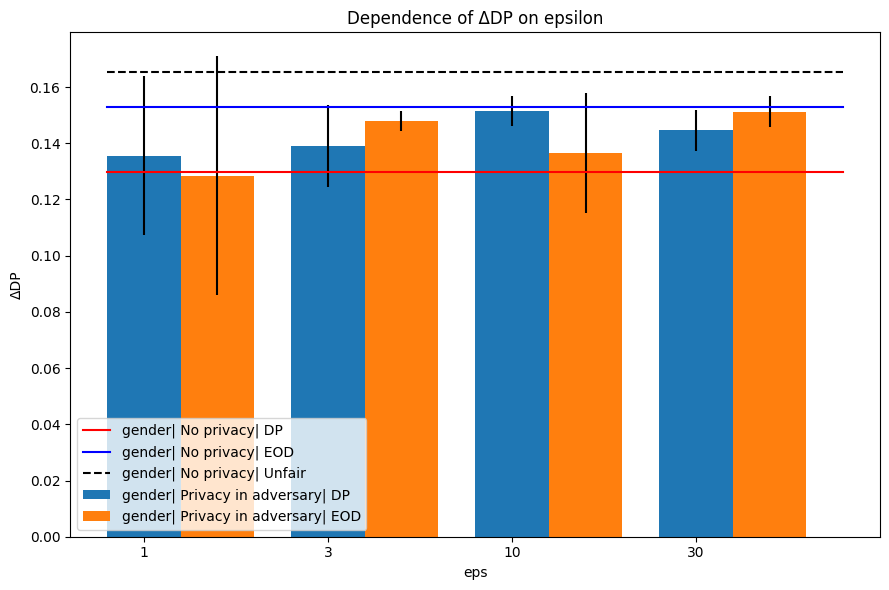

In [521]:
colors = ['r', 'b']
metrics = ['ΔDP']
ids_bar = [
    (0, 2, 4),
    (1, 3, 5),
    (0, 1),
    (2, 3),
    (4, 5)
]
ids_plt = [
    (6,),
    (7,),
    (6, 7),
    (6, 7),
    (6, 7)
]
for metric in metrics:
    for ids in zip(ids_bar, ids_plt):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9, 6))
        g_bar = [gen_l(metric)[i] for i in ids[0]]
        c_bar = [comb[i] for i in ids[0]]
        ax = plot_res(fig,ax,g_bar, metric, c_bar)
        for j, idx in enumerate(ids[1]):
            ax = add_no_pr(ax, gen_l(metric)[idx], comb[idx], metric, color=colors[j])
        ax = add_unfair(ax, metric)
        #ax.set_ylim(0.7, 0.9)
        #plt.savefig(f'imgs/{metric}_{ids}')

## test2

gender| Privacy in autoencoder| DP [0.738, 0.733, 0.733, 0.744] [0.01, 0.002, 0.007, 0.023]
gender| Privacy in classifier| DP [0.73, 0.738, 0.742, 0.738] [0.019, 0.019, 0.02, 0.006]
gender| Privacy in adversary| DP [0.739, 0.743, 0.743, 0.747] [0.011, 0.012, 0.004, 0.005]
gender| Privacy in autoencoder| EOD [0.74, 0.734, 0.729, 0.73] [0.02, 0.004, 0.011, 0.004]
gender| Privacy in classifier| EOD [0.742, 0.734, 0.736, 0.739] [0.018, 0.011, 0.016, 0.009]
gender| Privacy in adversary| EOD [0.742, 0.745, 0.746, 0.743] [0.015, 0.003, 0.004, 0.003]
gender| No privacy| DP 0.747 0.007
gender| No privacy| EOD 0.743 0.003
gender| Privacy in autoencoder| DP [0.751, 0.763, 0.768, 0.724] [0.016, 0.008, 0.009, 0.046]
gender| Privacy in classifier| DP [0.724, 0.747, 0.736, 0.756] [0.036, 0.017, 0.028, 0.009]
gender| Privacy in adversary| DP [0.757, 0.768, 0.772, 0.777] [0.033, 0.026, 0.008, 0.008]
gender| Privacy in autoencoder| EOD [0.741, 0.763, 0.746, 0.76] [0.032, 0.009, 0.038, 0.005]
gender| Pri

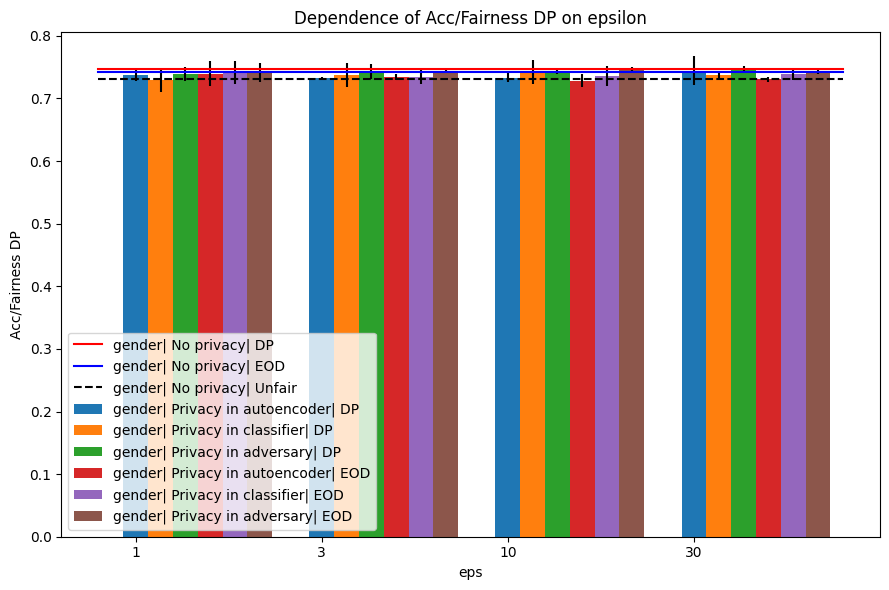

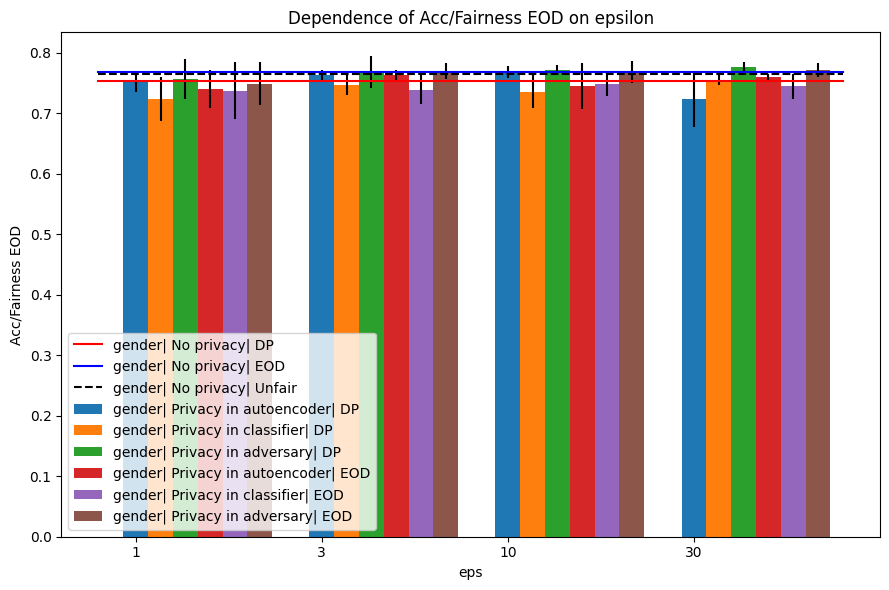

In [517]:
colors = ['r', 'b']
metrics = ['Acc/Fairness DP', 'Acc/Fairness EOD']
ids_bar = [
    (0,2,4,1,3,5)
]
ids_plt = [
    (6, 7)
]
for metric in metrics:
    for ids in zip(ids_bar, ids_plt):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9, 6))
        g_bar = [gen_l(metric)[i] for i in ids[0]]
        c_bar = [comb[i] for i in ids[0]]
        ax = plot_res(fig,ax,g_bar, metric, c_bar)
        for j, idx in enumerate(ids[1]):
            ax = add_no_pr(ax, gen_l(metric)[idx], comb[idx], metric, color=colors[j])
        ax = add_unfair(ax, metric)
        #plt.savefig(f'imgs/{metric[5:]}_{ids}')
    print('='*40)

gender| Privacy in autoencoder| DP [0.738, 0.733, 0.733, 0.744] [0.01, 0.002, 0.007, 0.023]
gender| Privacy in autoencoder| EOD [0.74, 0.734, 0.729, 0.73] [0.02, 0.004, 0.011, 0.004]
gender| No privacy| DP 0.747 0.007
gender| No privacy| EOD 0.743 0.003
gender| Privacy in autoencoder| DP [0.751, 0.763, 0.768, 0.724] [0.016, 0.008, 0.009, 0.046]
gender| Privacy in autoencoder| EOD [0.741, 0.763, 0.746, 0.76] [0.032, 0.009, 0.038, 0.005]
gender| No privacy| DP 0.753 0.04
gender| No privacy| EOD 0.768 0.012


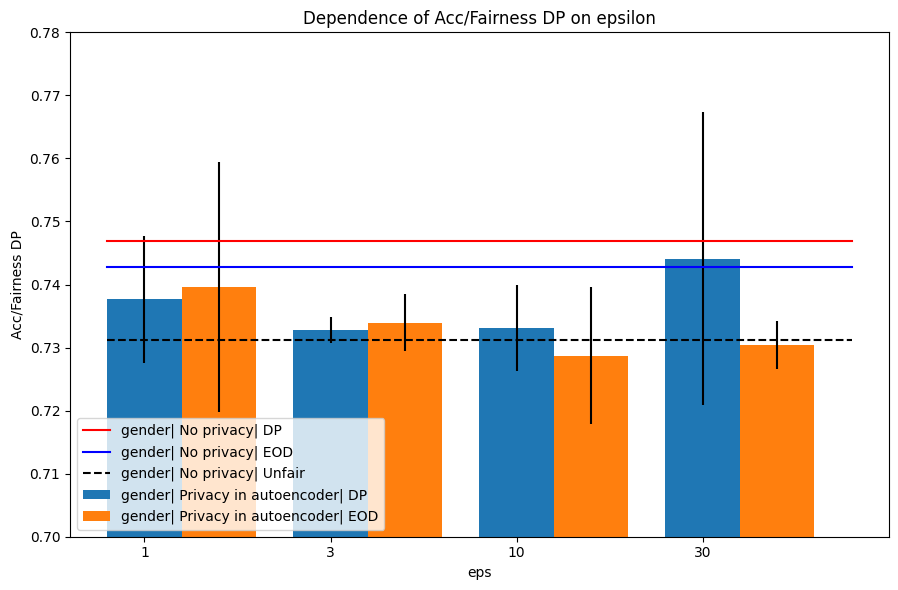

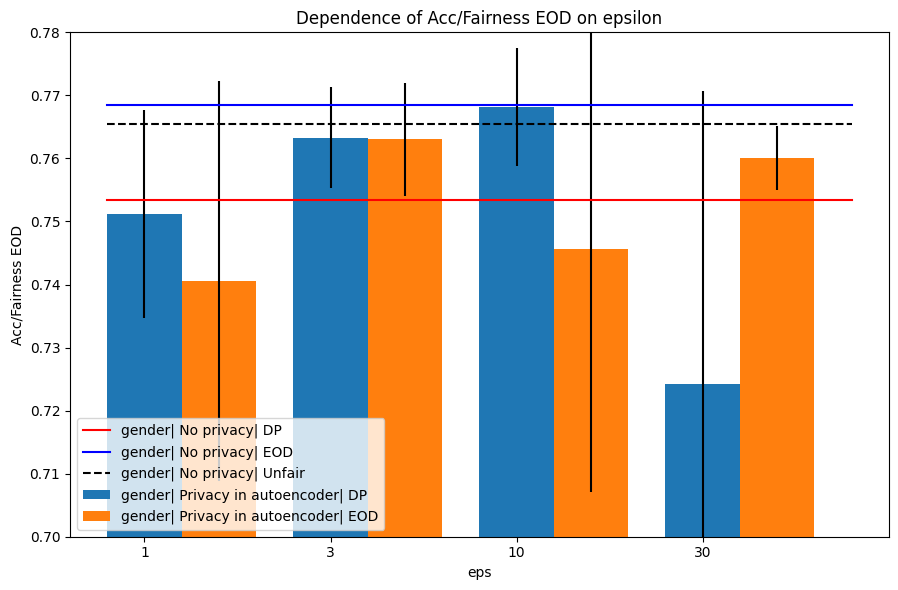

In [508]:
colors = ['r', 'b']
metrics = ['Acc/Fairness DP', 'Acc/Fairness EOD']
ids_bar = [
    (0,1)
]
ids_plt = [
    (6, 7)
]
for metric in metrics:
    for ids in zip(ids_bar, ids_plt):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9, 6))
        g_bar = [gen_l(metric)[i] for i in ids[0]]
        c_bar = [comb[i] for i in ids[0]]
        ax = plot_res(fig,ax,g_bar, metric, c_bar)
        for j, idx in enumerate(ids[1]):
            ax = add_no_pr(ax, gen_l(metric)[idx], comb[idx], metric, color=colors[j])
        ax = add_unfair(ax, metric)
        ax.set_ylim(0.7, 0.78)
        plt.savefig(f'imgs/{metric[4:]}_{ids}')
    print('='*40)